<a href="https://colab.research.google.com/github/i-m-alamin/Custom-CNN-classification-method-that-is-based-on-watershed-segmentation/blob/main/DDi_maccs_morgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow scikit-learn rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 62.0 MB/s eta 0:00:00


In [2]:
import time
import random
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
import math
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.DataStructs import TanimotoSimilarity, ConvertToNumpyArray
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Using GPU(s): {[device.name for device in physical_devices]}")
    except Exception as e:
        print(f"Error setting memory growth: {e}")
        sys.exit(1)  # Exit if memory growth setting fails
else:
    print("No GPU detected. Exiting...")
    sys.exit(1)  # Exit if no GPU is available

Using GPU(s): ['/physical_device:GPU:0']


In [21]:
class BalancedDDIPairSequence(Sequence):
    def __init__(self, pos_pairs, neg_pairs, morgan_fps, maccs_fps, batch_size=128):
        # Extract drug pairs from tuples - remove the label
        self.pos_pairs = [(a, b) for a, b, _ in pos_pairs]
        self.neg_pairs = [(a, b) for a, b, _ in neg_pairs]
        self.morgan = morgan_fps
        self.maccs = maccs_fps
        self.bs = batch_size
        # Calculate fingerprint dimensions
        self.fp_dim = (self.morgan[next(iter(self.morgan))].GetNumBits() +
                       self.maccs[next(iter(self.maccs))].GetNumBits())
        print(f"Balanced sequence with {len(self.pos_pairs)} positives and {len(self.neg_pairs)} negatives.")

    def __len__(self):
        # Ensure balanced batches
        return math.ceil(min(len(self.pos_pairs), len(self.neg_pairs)) / (self.bs // 2))

    def __getitem__(self, idx):
        # Sample balanced batch
        pos_batch = random.sample(self.pos_pairs, min(self.bs // 2, len(self.pos_pairs)))
        neg_batch = random.sample(self.neg_pairs, min(self.bs // 2, len(self.neg_pairs)))

        # Add labels back to the pairs
        pos_batch_with_labels = [(d1, d2, 1) for d1, d2 in pos_batch]
        neg_batch_with_labels = [(d1, d2, 0) for d1, d2 in neg_batch]

        batch = pos_batch_with_labels + neg_batch_with_labels
        random.shuffle(batch)

        X1 = np.zeros((len(batch), self.fp_dim), dtype=np.float32)
        X2 = np.zeros((len(batch), self.fp_dim), dtype=np.float32)
        y = np.zeros((len(batch),), dtype=np.int8)

        for i, (d1, d2, label) in enumerate(batch):
            # Fill Morgan + MACCS bits for drug1
            morgan_bits = self.morgan[d1].GetNumBits()
            maccs_bits = self.maccs[d1].GetNumBits()
            ConvertToNumpyArray(self.morgan[d1], X1[i][:morgan_bits])
            ConvertToNumpyArray(self.maccs[d1], X1[i][morgan_bits:morgan_bits + maccs_bits])

            # Fill Morgan + MACCS bits for drug2
            ConvertToNumpyArray(self.morgan[d2], X2[i][:morgan_bits])
            ConvertToNumpyArray(self.maccs[d2], X2[i][morgan_bits:morgan_bits + maccs_bits])

            y[i] = label

        return {"drug1_fp": X1, "drug2_fp": X2}, y

In [22]:
RDLogger.DisableLog('rdApp.*')

def load_positive_and_unique(csv_path):
    """Load your DDI CSV, coerce SMILES to str, drop invalid, return positives set + unique SMILES."""
    # 1) Read—with dtype=str to force everything to strings, then fill missing
    df = pd.read_csv(
        csv_path,
        header=0,
        usecols=['Drug1','Drug2','Y'],
        dtype={'Drug1': str, 'Drug2': str},
        low_memory=False
    )
    df['Drug1'] = df['Drug1'].fillna('').astype(str).str.strip()
    df['Drug2'] = df['Drug2'].fillna('').astype(str).str.strip()

    # 2) Drop any rows where SMILES is empty or the literal "nan"
    df = df[(df['Drug1'] != '') & (df['Drug2'] != '') &
            (~df['Drug1'].str.lower().eq('nan')) &
            (~df['Drug2'].str.lower().eq('nan'))]

    # 3) Keep only valid SMILES
    valid1 = df['Drug1'].apply(lambda s: Chem.MolFromSmiles(s) is not None)
    valid2 = df['Drug2'].apply(lambda s: Chem.MolFromSmiles(s) is not None)
    df = df[valid1 & valid2].reset_index(drop=True)

    # 4) Build bidirectional positives set
    pos = set(zip(df.Drug1, df.Drug2))
    pos |= set((b, a) for (a, b) in pos)

    unique_smiles = sorted({*df.Drug1, *df.Drug2})
    print(f"Loaded {len(df)} valid positive pairs, {len(unique_smiles)} unique SMILES")

    return pos, unique_smiles


def build_fingerprints(smiles_list, radius=2, nBits=1024):
    """Precompute Morgan & MACCS fingerprints for each SMILES."""
    morgan_fps, maccs_fps = {}, {}
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
        fp2 = MACCSkeys.GenMACCSKeys(mol)
        morgan_fps[smi] = fp1
        maccs_fps[smi] = fp2
    print(f"[2] Precomputed fingerprints for {len(morgan_fps)} molecules")
    return morgan_fps, maccs_fps

def sample_negatives(unique_smiles, positives, morgan_fps, threshold=0.8):
    """
    Randomly sample negative pairs until matching number of unique positives.
    Skip any sample in positives or similarity >= threshold.
    """
    # count only one direction for positives
    pos_pairs = [(a,b) for (a,b) in positives if a < b]
    num_needed = len(pos_pairs)
    negs = []
    seen = set()
    print(f"[3] Sampling {num_needed} negatives with sim<{threshold} ...")
    while len(negs) < num_needed:
        d1, d2 = random.sample(unique_smiles, 2)
        key = tuple(sorted((d1,d2)))
        if key in seen or (d1,d2) in positives:
            continue
        seen.add(key)
        sim = TanimotoSimilarity(morgan_fps[d1], morgan_fps[d2])
        if sim < threshold:
            negs.append((d1, d2, 0))
    print(f"[3] Sampled {len(negs)} negative pairs")
    return pos_pairs, negs


In [23]:
def fp_to_array(fp):
    """Convert RDKit ExplicitBitVect to numpy array of 0/1 ints."""
    arr = np.zeros((fp.GetNumBits(),), dtype=np.int8)
    ConvertToNumpyArray(fp, arr)
    return arr

def build_feature_matrix(pos_pairs, neg_pairs, morgan_fps, maccs_fps):
    """
    Concatenate pos/neg, shuffle, and build X (concatenated fingerprints) & y arrays.
    """
    all_pairs = [(a,b,1) for (a,b) in pos_pairs] + neg_pairs
    random.shuffle(all_pairs)
    n = len(all_pairs)
    # fingerprint dims
    fp_dim = fp_to_array(next(iter(morgan_fps.values()))).shape[0] + \
             fp_to_array(next(iter(maccs_fps.values()))).shape[0]
    X = np.zeros((n, fp_dim * 2), dtype=np.float32)
    y = np.zeros((n,), dtype=np.int8)
    print(f"[4] Building feature matrix for {n} pairs (each drug has {fp_dim} dims)...")
    for i, (d1, d2, label) in enumerate(all_pairs):
        v1 = np.concatenate([fp_to_array(morgan_fps[d1]), fp_to_array(maccs_fps[d1])])
        v2 = np.concatenate([fp_to_array(morgan_fps[d2]), fp_to_array(maccs_fps[d2])])
        X[i] = np.hstack([v1, v2])
        y[i] = label
    print(f"[4] Feature matrix: X={X.shape}, y={y.shape}")
    return X, y

def build_ddi_model(input_dim, l2_reg=1e-3, dropout=0.5):
    inp1 = Input(shape=(input_dim // 2,), name="drug1_fp")
    inp2 = Input(shape=(input_dim // 2,), name="drug2_fp")

    def drug_subnet(x):
        x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = BatchNormalization()(x)
        return x

    emb1 = drug_subnet(inp1)
    emb2 = drug_subnet(inp2)

    merged = Concatenate()([emb1, emb2])
    x = Dense(128, activation="relu")(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid", name="ddi_pred")(x)

    return Model(inputs=[inp1, inp2], outputs=out, name="HybridDDIModel")


In [28]:
start_time = time.time()
csv_path = "/content/drugbank_ddi_dataset.csv"
SIM_THRESHOLD = 0.8

# 1) Load & clean
positives, unique_smiles = load_positive_and_unique(csv_path)

# 2) Precompute fingerprints
morgan_fps, maccs_fps = build_fingerprints(unique_smiles, radius=2, nBits=1024)

# 3) Sample negatives
pos_pairs, neg_pairs = sample_negatives(unique_smiles, positives, morgan_fps, threshold=SIM_THRESHOLD)

# ── 4) Prepare streaming batches instead of full X/y ───────────────
all_pairs = [(a, b, 1) for (a, b) in pos_pairs] + neg_pairs
random.shuffle(all_pairs)

# split on the list of tuples
from sklearn.model_selection import train_test_split

# Extract all unique drugs
all_drugs = set(d for pair in all_pairs for d in (pair[0], pair[1]))
train_drugs, test_drugs = train_test_split(list(all_drugs), test_size=0.2, random_state=42)

# First, split the train_pairs into positive and negative pairs
train_pos_pairs = [(a, b, 1) for a, b, label in train_pairs if label == 1]
train_neg_pairs = [(a, b, 0) for a, b, label in train_pairs if label == 0]

# Do the same for test_pairs
test_pos_pairs = [(a, b, 1) for a, b, label in test_pairs if label == 1]
test_neg_pairs = [(a, b, 0) for a, b, label in test_pairs if label == 0]

print(f"Train split: {len(train_pos_pairs)} positive, {len(train_neg_pairs)} negative")
print(f"Test split: {len(test_pos_pairs)} positive, {len(test_neg_pairs)} negative")

# Now correctly create the sequence objects
batch_size = 128
train_seq = BalancedDDIPairSequence(train_pos_pairs, train_neg_pairs, morgan_fps, maccs_fps, batch_size)
test_seq = BalancedDDIPairSequence(test_pos_pairs, test_neg_pairs, morgan_fps, maccs_fps, batch_size)
print(f"[4] Sequence lengths: train={len(train_seq)}, test={len(test_seq)}")


Loaded 191798 valid positive pairs, 1705 unique SMILES
[2] Precomputed fingerprints for 1705 molecules
[3] Sampling 191392 negatives with sim<0.8 ...
[3] Sampled 191392 negative pairs
Train split: 125611 positive, 121915 negative
Test split: 65781 positive, 69477 negative
Balanced sequence with 125611 positives and 121915 negatives.
Balanced sequence with 65781 positives and 69477 negatives.
[4] Sequence lengths: train=1905, test=1028


In [25]:
# ── 5) Build & compile your model (unchanged) ───────────────────────
model = build_ddi_model(train_seq.fp_dim * 2)
if tf.config.list_physical_devices("GPU"):
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    print("[5] Using mixed precision")

steps = len(train_seq)
lr_schedule = CosineDecay(1e-3, decay_steps=steps * 50, alpha=1e-4)
optimizer   = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# ── 6) Callbacks remain the same ───────────────────────────────────
callbacks = [
    EarlyStopping("val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("best_ddi_model.h5", monitor="val_loss", save_best_only=True),
    TensorBoard(log_dir="logs/ddi_model")
]

# ── 7) Fit on the Sequence ─────────────────────────────────────────
history = model.fit(
    train_seq,
    validation_data=test_seq,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

# ── 8) Save final model ───────────────────────────────────────────
model.save("hybrid_ddi_model_final.h5")
print(f"Done in {(time.time() - start_time)/60:.2f} minutes.")

[5] Using mixed precision


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1902/1905 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7853 - loss: 1.3263 - precision: 0.7078 - recall: 0.7398

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 66s 28ms/step - auc: 0.7855 - loss: 1.3255 - precision: 0.7079 - recall: 0.7399 - val_auc: 0.8283 - val_loss: 0.7326 - val_precision: 0.7984 - val_recall: 0.6369
Epoch 2/15
1904/1905 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8949 - loss: 0.5660 - precision: 0.8008 - recall: 0.8478

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - auc: 0.8949 - loss: 0.5660 - precision: 0.8008 - recall: 0.8478 - val_auc: 0.8287 - val_loss: 0.6931 - val_precision: 0.7855 - val_recall: 0.6772
Epoch 3/15
1902/1905 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.9009 - loss: 0.5329 - precision: 0.8067 - recall: 0.8521

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - auc: 0.9009 - loss: 0.5329 - precision: 0.8067 - recall: 0.8521 - val_auc: 0.8394 - val_loss: 0.6365 - val_precision: 0.7671 - val_recall: 0.7467
Epoch 4/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - auc: 0.9036 - loss: 0.5213 - precision: 0.8102 - recall: 0.8564 - val_auc: 0.8464 - val_loss: 0.6405 - val_precision: 0.7859 - val_recall: 0.7262
Epoch 5/15
1903/1905 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.9068 - loss: 0.5093 - precision: 0.8146 - recall: 0.8583

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - auc: 0.9068 - loss: 0.5093 - precision: 0.8146 - recall: 0.8583 - val_auc: 0.8426 - val_loss: 0.6350 - val_precision: 0.7849 - val_recall: 0.7144
Epoch 6/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - auc: 0.9093 - loss: 0.4980 - precision: 0.8162 - recall: 0.8612 - val_auc: 0.8469 - val_loss: 0.6553 - val_precision: 0.7955 - val_recall: 0.6944
Epoch 7/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - auc: 0.9102 - loss: 0.4923 - precision: 0.8158 - recall: 0.8625 - val_auc: 0.8382 - val_loss: 0.6822 - val_precision: 0.8177 - val_recall: 0.6137
Epoch 8/15
1903/1905 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9129 - loss: 0.4831 - precision: 0.8200 - recall: 0.8640

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - auc: 0.9129 - loss: 0.4831 - precision: 0.8200 - recall: 0.8640 - val_auc: 0.8443 - val_loss: 0.6176 - val_precision: 0.7837 - val_recall: 0.7224
Epoch 9/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - auc: 0.9134 - loss: 0.4793 - precision: 0.8196 - recall: 0.8676 - val_auc: 0.8473 - val_loss: 0.6585 - val_precision: 0.8124 - val_recall: 0.6632
Epoch 10/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - auc: 0.9156 - loss: 0.4739 - precision: 0.8231 - recall: 0.8663 - val_auc: 0.8496 - val_loss: 0.6194 - val_precision: 0.7933 - val_recall: 0.7153
Epoch 11/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - auc: 0.9161 - loss: 0.4677 - precision: 0.8231 - recall: 0.8695 - val_auc: 0.8505 - val_loss: 0.6493 - val_precision: 0.8157 - val_recall: 0.6539
Epoch 12/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - auc: 0.9173 - loss: 0.4631 - precision: 0.8248 - recall: 0.8714 - val_auc: 0.8473 - val_loss: 0.6438 - val_precision: 0.8028 - val_rec

1905/1905 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - auc: 0.9212 - loss: 0.4520 - precision: 0.8309 - recall: 0.8745 - val_auc: 0.8557 - val_loss: 0.6027 - val_precision: 0.7922 - val_recall: 0.7509
Epoch 15/15
1905/1905 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - auc: 0.9223 - loss: 0.4477 - precision: 0.8310 - recall: 0.8742 - val_auc: 0.8517 - val_loss: 0.6241 - val_precision: 0.8023 - val_recall: 0.6947


Done in 15.70 minutes.


In [26]:
# Evaluate on the test sequence
results = model.evaluate(test_seq, verbose=0)
metric_names = model.metrics_names
print("\nTest Set Performance:")
for name, value in zip(metric_names, results):
    print(f"  {name}: {value:.4f}")



Test Set Performance:
  loss: 0.6023
  compile_metrics: 0.8558


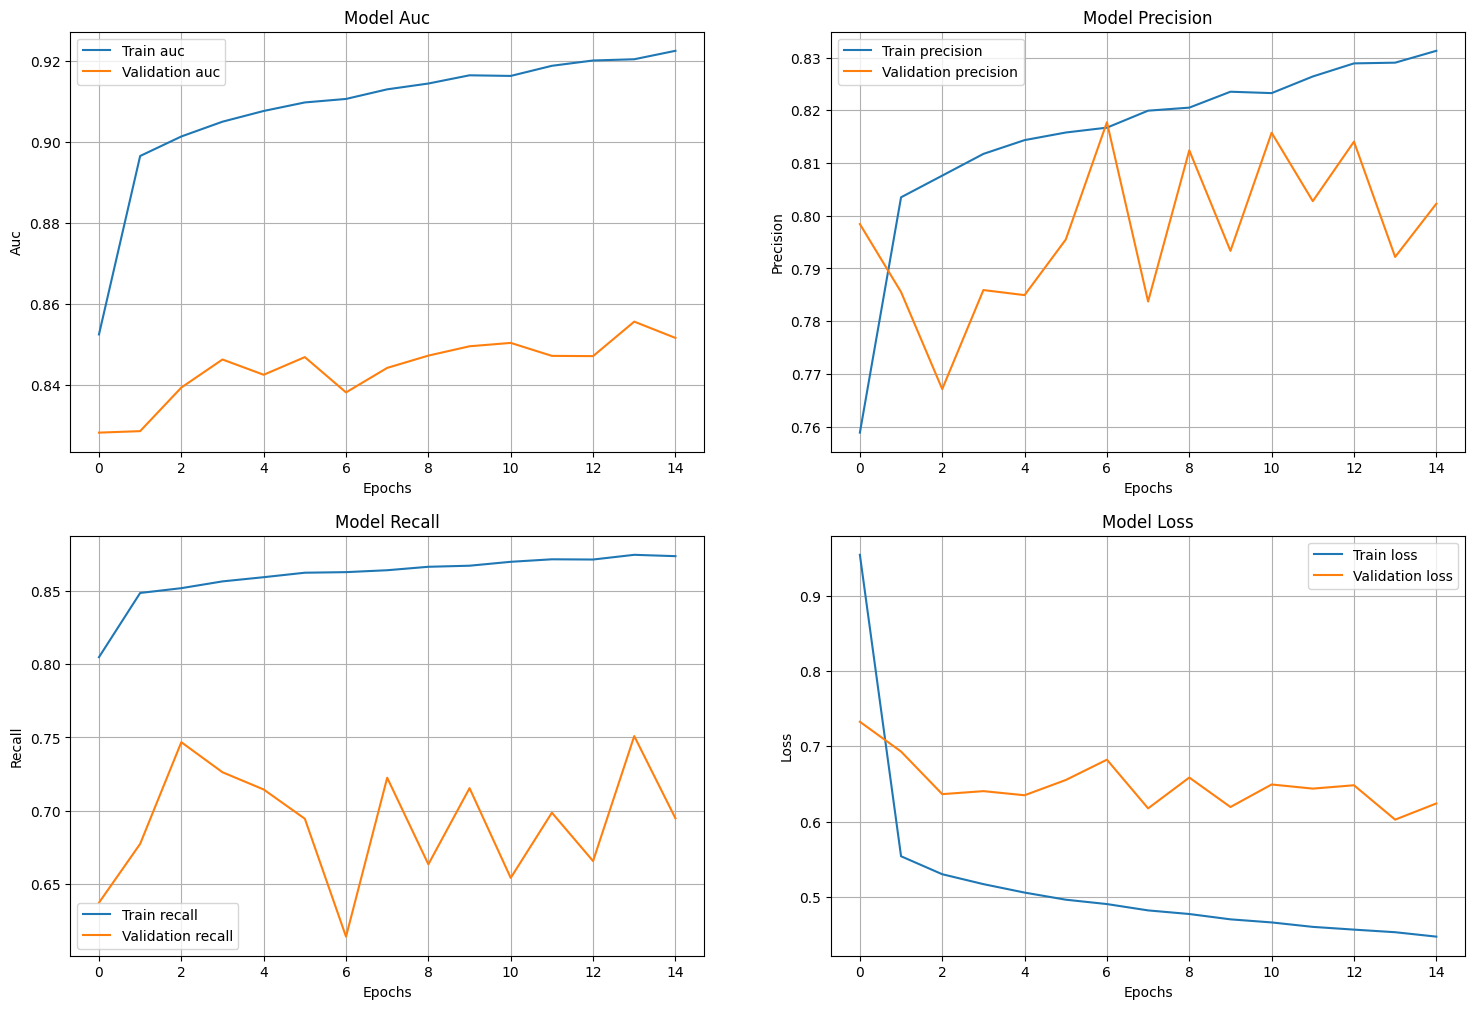

In [27]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ["auc", "precision", "recall", "loss"]
    plt.figure(figsize=(18, 12))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Model {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.show()

# Assuming 'history' is your training history object
plot_metrics(history)
